   rownames  county  year    crmrte    prbarr   prbconv   prbpris  avgsen  \
0         1       1    81  0.039885  0.289696  0.402062  0.472222    5.61   
1         2       1    82  0.038345  0.338111  0.433005  0.506993    5.59   
2         3       1    83  0.030305  0.330449  0.525703  0.479705    5.80   
3         4       1    84  0.034726  0.362525  0.604706  0.520104    6.89   
4         5       1    85  0.036573  0.325395  0.578723  0.497059    6.55   
5         6       1    86  0.034752  0.326062  0.512324  0.439863    6.90   
6         7       1    87  0.035604  0.298270  0.527596  0.436170    6.71   
7         8       3    81  0.016392  0.202899  0.869048  0.465753    8.45   
8         9       3    82  0.019065  0.162218  0.772152  0.377049    5.71   
9        10       3    83  0.015149  0.181586  1.028170  0.438356    8.69   

      polpc   density  ...       wtuc      wtrd      wfir      wser    wmfg  \
0  0.001787  2.307159  ...   333.6209  182.3330  272.4492  215.7335  229.

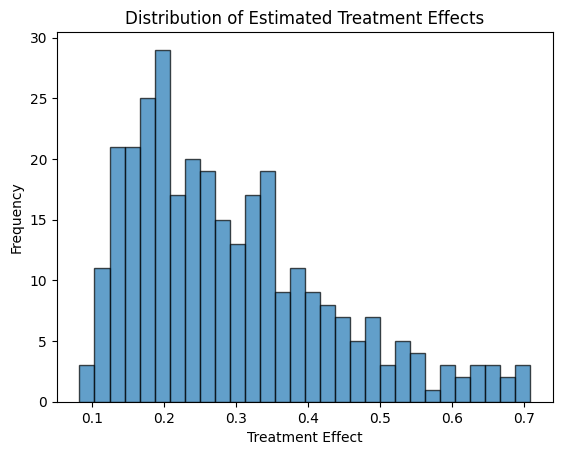

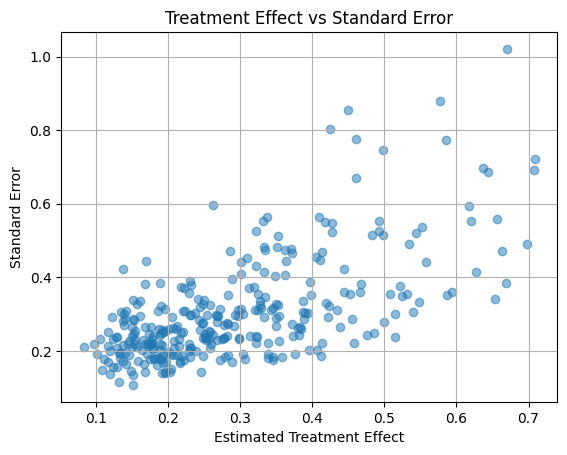

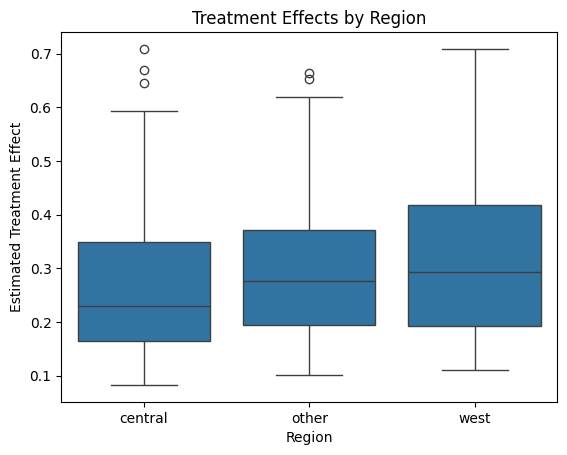

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from econml.grf import CausalForest
import patsy

# 数据导入
url = 'https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Crime.csv'
df = pd.read_csv(url)

# 删除缺失值
df = df.dropna()

print(df)

# 数据切分
train, hold = train_test_split(df, test_size=0.5, random_state=42)

# 提取结果变量 crmrte 犯罪率，并转换为一维数组
crmrte = train['crmrte'].values

# 提取干预变量 pctymle，并转换为一维数组
pctymle = train['pctymle'].values

# 构造训练数据矩阵 (包含交互项)
formula_features = '-1 + C(year) + prbarr + prbconv + prbpris + avgsen + polpc + density + taxpc + C(region) + C(smsa) + pctmin + wcon'
X_train = patsy.dmatrix(formula_features, data=train, return_type='dataframe')

# 构造测试数据矩阵
X_hold = patsy.dmatrix(formula_features, data=hold, return_type='dataframe')

# 因果森林建模
cf = CausalForest()
cf.fit(X_train.values, crmrte, pctymle)

# 获取因果效应和方差估计
predictions = cf.predict(X_hold.values, interval=True)
effects_hold = predictions[0].ravel()  # 确保为一维数组
variances_hold = (predictions[2] - predictions[1]) ** 2 / 4  # 使用置信区间估计方差

# 计算标准误差
SEs = np.sqrt(variances_hold.ravel())

# 打印前几个标准误差
print("前10个标准误差：", SEs[:10])

# 可视化部分

# 1. 效果估计的分布图
plt.hist(effects_hold, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Estimated Treatment Effects")
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

# 2. 效果估计与标准误差的散点图
plt.scatter(effects_hold, SEs, alpha=0.5)
plt.title("Treatment Effect vs Standard Error")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Standard Error")
plt.grid(True)
plt.show()

# 3. 分组效果估计的箱线图（按区域分组）
if 'region' in hold.columns:
    results = pd.DataFrame({
        'region': hold['region'].values,
        'effect': effects_hold
    })
    sns.boxplot(x='region', y='effect', data=results)
    plt.title("Treatment Effects by Region")
    plt.xlabel("Region")
    plt.ylabel("Estimated Treatment Effect")
    plt.show()

In [2]:
print(df)

     rownames  county  year    crmrte    prbarr   prbconv   prbpris  avgsen  \
0           1       1    81  0.039885  0.289696  0.402062  0.472222    5.61   
1           2       1    82  0.038345  0.338111  0.433005  0.506993    5.59   
2           3       1    83  0.030305  0.330449  0.525703  0.479705    5.80   
3           4       1    84  0.034726  0.362525  0.604706  0.520104    6.89   
4           5       1    85  0.036573  0.325395  0.578723  0.497059    6.55   
..        ...     ...   ...       ...       ...       ...       ...     ...   
625       626     197    83  0.015575  0.226667  0.480392  0.428571    7.77   
626       627     197    84  0.013662  0.204188  1.410260  0.372727   10.11   
627       628     197    85  0.013086  0.180556  0.830769  0.333333    5.96   
628       629     197    86  0.012874  0.112676  2.250000  0.244444    7.68   
629       630     197    87  0.014193  0.207595  1.182930  0.360825   12.23   

        polpc   density  ...       wtuc      wtrd  